In [1]:
#importing the necessary libraries
import boto3
import io

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Obtain the data from S3

In [2]:
#initialzing client object to interact with S3
access_key = #KEY REMOVED DUE TO SECURITY REASONS
secret_key = #KEY REMOVED DUE TO SECURITY REASONS
session = boto3.Session(aws_access_key_id=access_key, aws_secret_access_key=secret_key)
s3 = session.client('s3')

In [3]:
# Set the bucket name and file name
bucket_name = 'test-bucket-for-josef'
file_name = 'houses_Madrid.csv'

# Get the file object from S3
s3_object = s3.get_object(Bucket=bucket_name, Key=file_name)

# Read the CSV file into a pandas dataframe
data = pd.read_csv(s3_object['Body'])
data.head()

,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,False,True,False,False
1,1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,False,False,True,False
4,4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,True,True,True,True


# Pre processing

In [4]:
#obtaining info about our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    21742 non-null  int64  
 1   id                            21742 non-null  int64  
 2   title                         21742 non-null  object 
 3   subtitle                      21742 non-null  object 
 4   sq_mt_built                   21616 non-null  float64
 5   sq_mt_useful                  8228 non-null   float64
 6   n_rooms                       21742 non-null  int64  
 7   n_bathrooms                   21726 non-null  float64
 8   n_floors                      1437 non-null   float64
 9   sq_mt_allotment               1432 non-null   float64
 10  latitude                      0 non-null      float64
 11  longitude                     0 non-null      float64
 12  raw_address                   16277 non-null  object 
 13  i

In [5]:
#missing values - we observe a high number of missing values among some features
print(data.isnull().sum())

Unnamed: 0                          0
id                                  0
title                               0
subtitle                            0
sq_mt_built                       126
sq_mt_useful                    13514
n_rooms                             0
n_bathrooms                        16
n_floors                        20305
sq_mt_allotment                 20310
latitude                        21742
longitude                       21742
raw_address                      5465
is_exact_address_hidden             0
street_name                      5905
street_number                   15442
portal                          21742
floor                            2607
is_floor_under                   1170
door                            21742
neighborhood_id                     0
operation                           0
rent_price                          0
rent_price_by_area              21742
is_rent_price_known                 0
buy_price                           0
buy_price_by

In [6]:
#maintain just features, that are useful for our forecast / discard features with too many missing values / irrelant ones
data = data.filter(['sq_mt_built','n_rooms','n_bathrooms','neighborhood_id', 
                    "house_type_id", "is_new_development", "has_central_heating","has_lift",
                    'buy_price','has_parking',])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sq_mt_built          21616 non-null  float64
 1   n_rooms              21742 non-null  int64  
 2   n_bathrooms          21726 non-null  float64
 3   neighborhood_id      21742 non-null  object 
 4   house_type_id        21351 non-null  object 
 5   is_new_development   20750 non-null  object 
 6   has_central_heating  13608 non-null  object 
 7   has_lift             19356 non-null  object 
 8   buy_price            21742 non-null  int64  
 9   has_parking          21742 non-null  bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 1.5+ MB


In [7]:
#Create the neighborhood vector from string in data
data["neighborhood_id"] = data["neighborhood_id"].str.split().str[-1]

#see which values are there
set(data["neighborhood_id"])

{'Arganzuela',
 'Barajas',
 'Carabanchel',
 'Centro',
 'Chamartín',
 'Chamberí',
 'Fuencarral',
 'Hortaleza',
 'Latina',
 'Lineal',
 'Moncloa',
 'Moratalaz',
 'Retiro',
 'Salamanca',
 'Tetuán',
 'Usera',
 'Vallecas',
 'Vicálvaro',
 'Villaverde'}

In [8]:
# Creating a Downtown variable 

# Create a list of downtown neighborhoods
downtown_neighborhoods = ['Centro', 'Chamberí', 'Retiro', 'Salamanca', 'Tetuán']

# Create a new column 'downtown' with values 1 for downtown neighborhoods and 0 for others
data['downtown'] = data['neighborhood_id'].apply(lambda x: 1 if x in downtown_neighborhoods else 0)


In [9]:
#Distribution of downtown apartments to non downtown apartments
house_type_counts = data["downtown"].value_counts()

# Print the counts
print(house_type_counts)

0    14887
1     6855
Name: downtown, dtype: int64


In [10]:
#Create the house type vector from string in data
data["house_type_id"] = data["house_type_id"].str.split().str[-1]

#see which values are there
set(data["house_type_id"])

{'Dúplex', 'Pisos', 'chalet', nan, 'Áticos'}

In [11]:
#Since most of the data is pisos, we think it makes most sense to only predict those

# Count the number of occurrences of each value in the house_type_id column
house_type_counts = data["house_type_id"].value_counts()

# Print the counts
print(house_type_counts)

Pisos     17705
chalet     1938
Áticos     1032
Dúplex      676
Name: house_type_id, dtype: int64


In [12]:
# Filter for only "Pisos"
data = data[data["house_type_id"] == "Pisos"]

In [13]:
#how many features have missing values? -> we will impute the other values 
print(data.isnull().sum())

sq_mt_built               0
n_rooms                   0
n_bathrooms              11
neighborhood_id           0
house_type_id             0
is_new_development      870
has_central_heating    6431
has_lift                424
buy_price                 0
has_parking               0
downtown                  0
dtype: int64


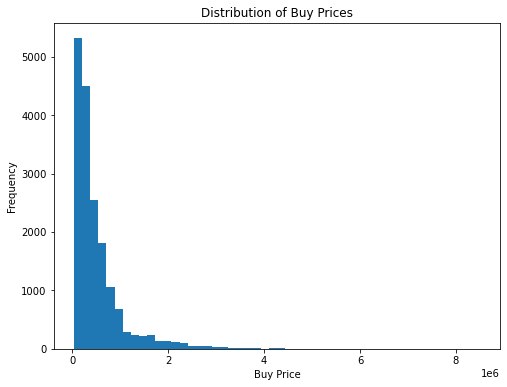

In [14]:
#Verify the distribution of the target -> we see it is highly left skewed

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the histogram
plt.hist(data["buy_price"], bins=50)

# Set the plot title and axis labels
plt.title("Distribution of Buy Prices")
plt.xlabel("Buy Price")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [15]:
#due to left skewage of the price, we will take the logarithm of price to account for this
data['buy_price']= np.log(data['buy_price'])


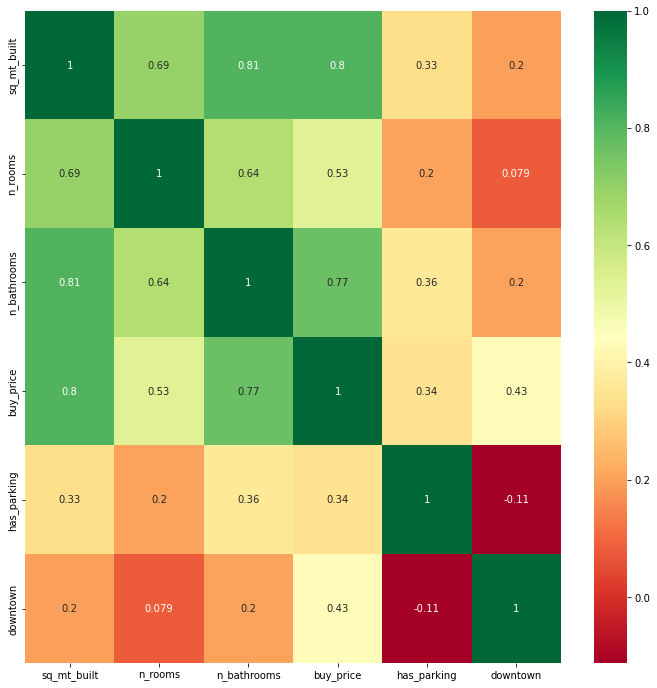

In [16]:
#multicollinearity analyis -> drop features that have absolute correlation coefficinet of 0.7 with other features
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12,12))

g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")


In [17]:
#we see that sqm, number of roooms, and number of bathrooms display multicollinearity
#we keep just the squaremeters in model to avoid multicollinearity
data = data.drop(columns=["n_rooms"])

In [18]:
# Define a dictionary to map values to 0/1
mapping = {False: 0, True: 1}

# Map the values to 0/1 for our TRUE/False columns
data['has_central_heating'] = data['has_central_heating'].map(mapping)
data['has_parking'] = data['has_parking'].map(mapping)
data['is_new_development'] = data['is_new_development'].map(mapping)

In [19]:
data

,sq_mt_built,n_bathrooms,neighborhood_id,house_type_id,is_new_development,has_central_heating,has_lift,buy_price,has_parking,downtown
0,64.0,1.0,Villaverde,Pisos,0.0,NaN,False,11.350407,0,0
1,70.0,1.0,Villaverde,Pisos,0.0,NaN,True,11.774520,0,0
2,94.0,2.0,Villaverde,Pisos,0.0,0.0,True,11.879282,0,0
3,64.0,1.0,Villaverde,Pisos,0.0,NaN,True,11.607326,0,0
4,108.0,2.0,Villaverde,Pisos,0.0,NaN,True,12.468437,1,0
...,...,...,...,...,...,...,...,...,...,...
21735,88.0,2.0,Barajas,Pisos,0.0,0.0,True,12.793859,1,0
21736,99.0,2.0,Barajas,Pisos,0.0,0.0,True,12.762827,1,0
21738,96.0,2.0,Barajas,Pisos,0.0,0.0,True,12.959844,1,0
21739,175.0,2.0,Barajas,Pisos,0.0,0.0,False,13.429848,1,0


In [20]:
#Create our target array and feature matrix
X = data.drop(columns = ["buy_price", "neighborhood_id", "house_type_id"])
y = data["buy_price"]

In [21]:
#do train test split split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, random_state= 42)

In [22]:
X

,sq_mt_built,n_bathrooms,is_new_development,has_central_heating,has_lift,has_parking,downtown
0,64.0,1.0,0.0,NaN,False,0,0
1,70.0,1.0,0.0,NaN,True,0,0
2,94.0,2.0,0.0,0.0,True,0,0
3,64.0,1.0,0.0,NaN,True,0,0
4,108.0,2.0,0.0,NaN,True,1,0
...,...,...,...,...,...,...,...
21735,88.0,2.0,0.0,0.0,True,1,0
21736,99.0,2.0,0.0,0.0,True,1,0
21738,96.0,2.0,0.0,0.0,True,1,0
21739,175.0,2.0,0.0,0.0,False,1,0


# Setting up pipeline 

In [23]:
#defining the pipeline

steps = [('imputer', SimpleImputer(strategy='most_frequent')),
          ('classifier', LinearRegression())]


pipe = Pipeline(steps)

# Training the model and evaluate its performance

In [24]:
# train our model 
pipe.fit(X_train, y_train)

# Determine the predicted Y values
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Calculate the mean squared error for the training and test predictions
#-> we see that the errors are not far apart. It seems that we are not overfitting
print(mean_squared_error(y_train, y_pred_train))
print(mean_squared_error(y_test, y_pred_test))

0.12829999576437162
0.1331909312140403


In [25]:
# Obtain the R-squared of our model -> we found a good model that explains 87% of the variance of y
#we see that we are not overfiiting as the R-squared are very identical 

print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.8094974240730425
0.8086672069401468


# Store the coefficients of the model as a CSV file in S3 bucket

Create a pandas dataframe with the name of the coefficients and their values

In [26]:
# Get the coefficients and intercept from the linear regression model in the pipeline
coef = pipe.named_steps['classifier'].coef_
intercept = pipe.named_steps['classifier'].intercept_

# Create a list of tuples containing the feature name and coefficient
coef_list = [('Intercept', intercept)]
for name, value in zip(X.columns, coef):
    coef_list.append((name, value))

# Create a DataFrame with the feature names and coefficients as columns, with values in rows
coef_df = pd.DataFrame(coef_list, columns=['Feature', 'Coefficient'])

# Print the DataFrame
coef_df

,Feature,Coefficient
0,Intercept,11.346693
1,sq_mt_built,0.004995
2,n_bathrooms,0.182255
3,is_new_development,0.116267
4,has_central_heating,0.095180
5,has_lift,0.401781
6,has_parking,0.112571
7,downtown,0.451652


Convert pandas dataframe to a CSV file and upload it

In [27]:
# write the dataframe to a BytesIO object
csv_buffer = io.BytesIO()
coef_df.to_csv(csv_buffer, index=False, encoding='utf-8')
csv_buffer.seek(0)

# upload the file to S3
bucket_name = 'test-bucket-for-josef'
file_name = 'parameters1.csv'
s3.upload_fileobj(csv_buffer, bucket_name, file_name)

# API URL 

https://e0aapcf4hg.execute-api.us-east-1.amazonaws.com/pred